### multi-class classification

In [30]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

tensor([[-5.8290,  1.3261],
        [-2.7268, 10.4744],
        [-7.7514, -4.3266],
        [-5.4622,  1.6811],
        [-4.7886,  2.8629]]) tensor([0., 1., 2., 3., 3.])


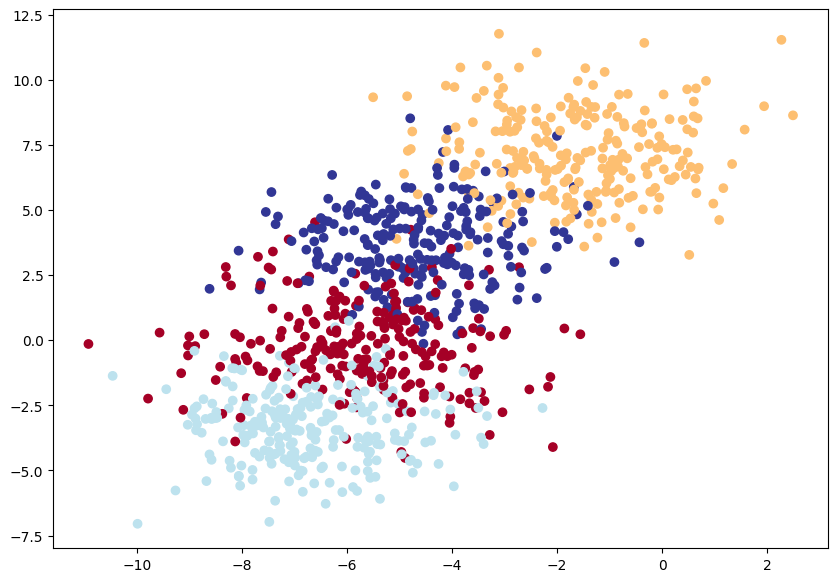

In [31]:
# creating the data - blobs for multiclass example
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 22

# 1. create data
X_blob , y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels 
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. create tensors
X_blob = torch.from_numpy(X_blob).type(torch.float) 
y_blob = torch.from_numpy(y_blob).type(torch.float) 

print(X_blob[:5] ,  y_blob[:5])

# 3. split the data in to trani and test
X_train ,X_test,y_train,y_test = train_test_split(X_blob , y_blob , test_size=0.2 , random_state=RANDOM_SEED)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [32]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [33]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES, 
                    output_features=NUM_CLASSES, 
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [42]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(), 
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

In [43]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob.to(device))[:5]

tensor([[ 1.5386, -0.4626,  1.6506,  1.3839],
        [ 0.1853, -1.6724, -0.0160,  1.2216],
        [ 2.3763,  0.2848,  2.6820,  1.4853],
        [ 1.4253, -0.5078,  1.5192,  1.3280],
        [ 1.1831, -0.6620,  1.2299,  1.2521]], grad_fn=<SliceBackward0>)

In [44]:
# How many elements in a single prediction sample?
model_4(X_blob.to(device))[0].shape, NUM_CLASSES 

(torch.Size([4]), 4)

In [45]:
# Make prediction logits with model
y_logits = model_4(X_blob.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1) 
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 1.5386, -0.4626,  1.6506,  1.3839],
        [ 0.1853, -1.6724, -0.0160,  1.2216],
        [ 2.3763,  0.2848,  2.6820,  1.4853],
        [ 1.4253, -0.5078,  1.5192,  1.3280],
        [ 1.1831, -0.6620,  1.2299,  1.2521]], grad_fn=<SliceBackward0>)
tensor([[0.3215, 0.0435, 0.3596, 0.2754],
        [0.2087, 0.0326, 0.1706, 0.5882],
        [0.3459, 0.0427, 0.4695, 0.1419],
        [0.3174, 0.0459, 0.3487, 0.2880],
        [0.3051, 0.0482, 0.3197, 0.3269]], grad_fn=<SliceBackward0>)


In [46]:
# Sum the first sample output of the softmax activation function 
torch.sum(y_pred_probs[0])

tensor(1.0000, grad_fn=<SumBackward0>)

In [47]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3215, 0.0435, 0.3596, 0.2754], grad_fn=<SelectBackward0>)
tensor(2)


### Creating a training and testing loop for a multi-class PyTorch model

In [48]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [55]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob.to(device), y_blob.to(device)
X_blob_test, y_blob_test = X_blob.to(device), y_blob.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits 
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train.type(torch.LongTensor)) 
    acc = accuracy_fn(y_true=y_blob,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test.type(torch.LongTensor))
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%") 

Epoch: 0 | Loss: 0.88920, Acc: 69.60% | Test Loss: 0.80280, Test Acc: 70.70%
Epoch: 10 | Loss: 0.54365, Acc: 82.10% | Test Loss: 0.53009, Test Acc: 82.10%
Epoch: 20 | Loss: 0.45637, Acc: 83.20% | Test Loss: 0.45162, Test Acc: 83.20%
Epoch: 30 | Loss: 0.42393, Acc: 83.50% | Test Loss: 0.42201, Test Acc: 83.60%
Epoch: 40 | Loss: 0.41021, Acc: 83.50% | Test Loss: 0.40934, Test Acc: 83.50%
Epoch: 50 | Loss: 0.40368, Acc: 83.20% | Test Loss: 0.40323, Test Acc: 83.20%
Epoch: 60 | Loss: 0.40016, Acc: 83.20% | Test Loss: 0.39990, Test Acc: 83.20%
Epoch: 70 | Loss: 0.39799, Acc: 83.40% | Test Loss: 0.39782, Test Acc: 83.30%
Epoch: 80 | Loss: 0.39930, Acc: 82.90% | Test Loss: 0.40302, Test Acc: 82.60%
Epoch: 90 | Loss: 0.44436, Acc: 80.40% | Test Loss: 0.45735, Test Acc: 80.50%


In [56]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  4.4348,  -3.3519,   0.3647,   3.4581],
        [ -5.4231,  13.6334, -19.9007,   8.7032],
        [ 10.5310, -13.8526,  12.8905,   0.2189],
        [  3.8276,  -2.4411,  -0.5988,   3.5840],
        [  2.3055,   0.0315,  -3.4125,   4.1756],
        [ -3.2578,   8.7593, -13.0463,   5.8878],
        [  5.8986,  -6.4882,   4.6650,   1.7856],
        [  4.9631,  -5.4361,   3.9185,   1.4688],
        [  9.6688, -11.7735,   9.8703,   1.5413],
        [ -5.0015,  12.1909, -17.5289,   7.4371]])

In [57]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([0, 1, 2, 0, 3, 1, 0, 0, 2, 1])
Labels: tensor([0., 1., 2., 3., 3., 1., 2., 0., 2., 1.])
Test accuracy: 82.89999999999999%


In [59]:
from helper_functions import plot_decision_boundary

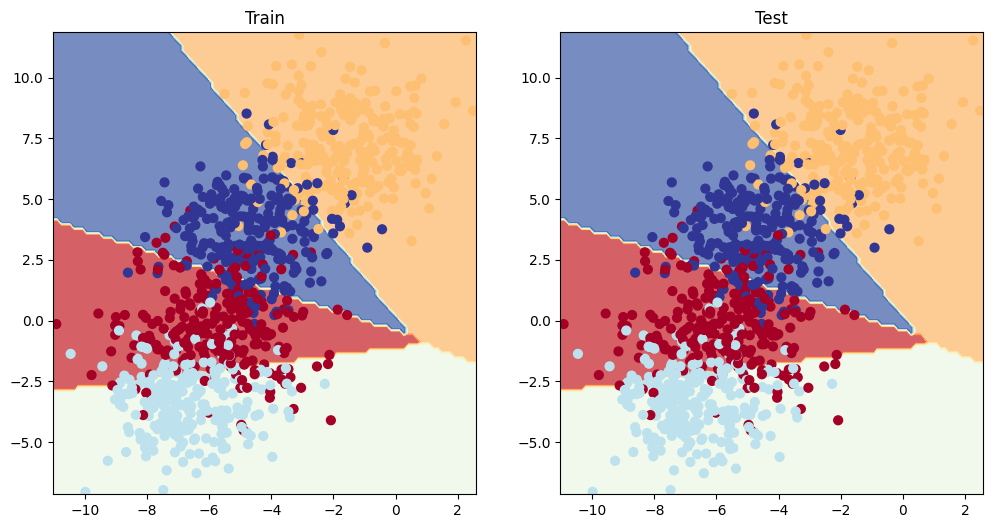

In [60]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)

### More classification evaluation metrics

![image](./images/6.png)

In [62]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

tensor(0.8290)